# Лабораторная работа 2.2.1: Математическая модель полета тела

## Формулировка задачи

Исследование траектории полета тела с учетом сопротивления воздуха. Рассматриваются два типа сопротивления: линейное и квадратичное.

## Система уравнений

**Линейное сопротивление:**
$$\begin{cases}
\frac{dx}{dt} = v_x \\
\frac{dy}{dt} = v_y \\
\frac{dv_x}{dt} = -\alpha v_x \\
\frac{dv_y}{dt} = -g - \alpha v_y
\end{cases}$$

**Квадратичное сопротивление:**
$$\begin{cases}
\frac{dx}{dt} = v_x \\
\frac{dy}{dt} = v_y \\
\frac{dv_x}{dt} = -\frac{C}{m}v \cdot v_x \\
\frac{dv_y}{dt} = -g - \frac{C}{m}v \cdot v_y
\end{cases}$$

где $v = \sqrt{v_x^2 + v_y^2}$ - модуль скорости.

## Методы решения

1. **Аналитическое решение** для линейного сопротивления (через интегрирование)
2. **Численное решение** методом Рунге-Кутты (RK45) для обоих типов сопротивления
3. **Классическое решение** без учета сопротивления (для сравнения)

## Параметры

- Масса: $m = 0.1$ кг
- Начальная скорость: $V_0 = 15$ м/с
- Угол броска: $\alpha = 45°$
- Коэффициент сопротивления: $C = 0.02$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import brentq
import pandas as pd

# Параметры
m = 0.1       
g = 9.81     
V0 = 15
alpha_deg = 45  
C = 0.02
alpha = C / m  # линейное сопротивление

alpha_rad = np.radians(alpha_deg)
vx0 = V0 * np.cos(alpha_rad)
vy0 = V0 * np.sin(alpha_rad)

In [2]:
# линейного сопротивления
def system_ode_linear(t, state):
    x, y, vx, vy = state
    dxdt = vx
    dydt = vy
    dvxdt = -alpha * vx
    dvydt = -g - alpha * vy
    return [dxdt, dydt, dvxdt, dvydt]

def ground_contact(t, state):
    return state[1]

ground_contact.terminal = True
ground_contact.direction = -1

solution_linear = solve_ivp(
    system_ode_linear,
    (0, 10),
    [0, 0, vx0, vy0],
    method='RK45',
    events=ground_contact,
    dense_output=True,
    rtol=1e-10
)

t_num_linear = np.linspace(0, solution_linear.t_events[0][0], 500)
sol_values_linear = solution_linear.sol(t_num_linear)
x_num_linear = sol_values_linear[0]
y_num_linear = sol_values_linear[1]


$$\begin{cases}
\frac{dx}{dt} = v_x \\
\frac{dy}{dt} = v_y \\
\frac{dv_x}{dt} = -\alpha v_x \\
\frac{dv_y}{dt} = -g - \alpha v_y
\end{cases}$$


In [3]:
# квадратичного сопротивления
def system_ode_quadratic(t, state):
    x, y, vx, vy = state
    v = np.sqrt(vx**2 + vy**2)
    dxdt = vx
    dydt = vy
    dvxdt = -(C/m) * v * vx
    dvydt = -g - (C/m) * v * vy
    return [dxdt, dydt, dvxdt, dvydt]

solution_quadratic = solve_ivp(
    system_ode_quadratic,
    (0, 10),
    [0, 0, vx0, vy0],
    method='RK45',
    events=ground_contact,
    dense_output=True,
    rtol=1e-10
)

t_num_quadratic = np.linspace(0, solution_quadratic.t_events[0][0], 500)
sol_values_quadratic = solution_quadratic.sol(t_num_quadratic)
x_num_quadratic = sol_values_quadratic[0]
y_num_quadratic = sol_values_quadratic[1]


$$\begin{cases}
\frac{dx}{dt} = v_x \\
\frac{dy}{dt} = v_y \\
\frac{dv_x}{dt} = -\frac{C}{m}v \cdot v_x \\
\frac{dv_y}{dt} = -g - \frac{C}{m}v \cdot v_y
\end{cases}$$


In [4]:
# линейное сопротивление
def y_func(t):
    return ((vy0 + g/alpha)/alpha) * (1 - np.exp(-alpha * t)) - (g/alpha) * t

# Находим время полета численно
t_flight_analytical = brentq(y_func, 0.1, 5.0)

t_analytical = np.linspace(0, t_flight_analytical, 500)
x_analytical = (vx0 / alpha) * (1 - np.exp(-alpha * t_analytical))
y_analytical = ((vy0 + g/alpha)/alpha) * (1 - np.exp(-alpha * t_analytical)) - (g/alpha) * t_analytical

$$\begin{cases}
x(t) = \frac{v_{x0}}{\alpha}(1 - e^{-\alpha t}) \\
y(t) = \frac{v_{y0} + g/\alpha}{\alpha}(1 - e^{-\alpha t}) - \frac{g}{\alpha}t \\
v_x(t) = v_{x0}e^{-\alpha t} \\
v_y(t) = (v_{y0} + g/\alpha)e^{-\alpha t} - g/\alpha
\end{cases}$$


In [5]:
# Без сопротивления
t_classic = 2 * vy0 / g
t_class_range = np.linspace(0, t_classic, 100)
x_class = vx0 * t_class_range
y_class = vy0 * t_class_range - 0.5 * g * t_class_range**2

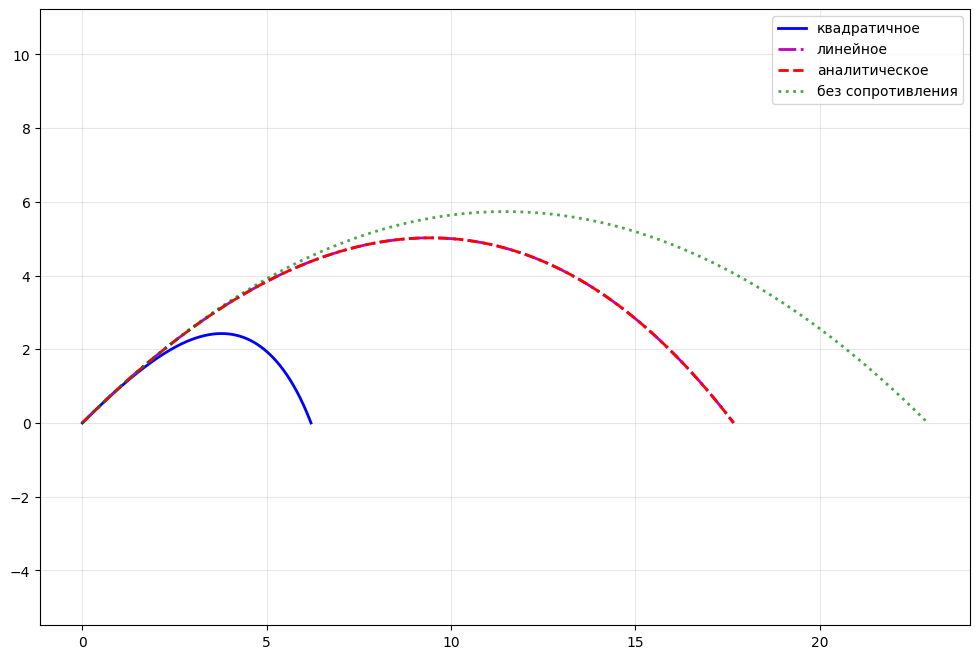

,,t(s),r(m),h(m)
0,квадратичное,1.387907,6.202105,2.425444
1,линейное,2.025962,17.668024,5.021732
2,аналитическое,2.025962,17.668024,5.021732
3,без сопротивления,2.162406,22.935780,5.733360


In [6]:
plt.figure(figsize=(12, 8))
plt.plot(x_num_quadratic, y_num_quadratic, 'b-', linewidth=2, label='квадратичное')
plt.plot(x_num_linear, y_num_linear, 'm-.', linewidth=2, label='линейное')
plt.plot(x_analytical, y_analytical, 'r--', linewidth=2, label='аналитическое')
plt.plot(x_class, y_class, 'g:', linewidth=2, alpha=0.7, label='без сопротивления')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.show()

results = pd.DataFrame({
    '': ['квадратичное', 'линейное', 'аналитическое', 'без сопротивления'],
    't(s)': [
        solution_quadratic.t_events[0][0],
        solution_linear.t_events[0][0],
        t_flight_analytical,
        t_classic
    ],
    'r(m)': [
        x_num_quadratic[-1],
        x_num_linear[-1],
        x_analytical[-1],
        x_class[-1]
    ],
    'h(m)': [
        np.max(y_num_quadratic),
        np.max(y_num_linear),
        np.max(y_analytical),
        np.max(y_class)
    ]
})

results